**Submission comment**

GitHub URL: https://github.com/seant2436/dscc202-402-spring2024.git

Vocareum Username: labuser104917-3014551@vocareum.com

## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2024">The Repo</a>.  If you are unclear on how to pull an updated copy using the GitHub command line, the following <a href="https://techwritingmatters.com/how-to-update-your-forked-repository-on-github">document</a> is helpful.  Be sure to add the professors and TAs as collaborators on your project. 

- lpalum@gmail.com GitHub ID: lpalum
- ajay.anand@rochester.edu GitHub ID: ajayan12
- divyamunot1999@gmail.com GitHub ID: divyamunot
- ylong6@u.Rochester.edu GitHub ID: NinaLong2077

Once you have updates your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://www.databricks.training/step-by-step/importing-courseware-from-github/index.html">Repos</a> feature.
Each student is expected to submit the URL of their project on GitHub with their code checked in on the main/master branch.  This illustration highlights the branching scheme that you may use to work on your code in steps and then merge your submission into your master branch before submitting.
</p>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/github.drawio.png">
<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches.  First, you may choose to start the bronze_stream and let it complete (read and append all of the source data) before preceeding and starting up the silver_stream.  This approach has latency associated with it but it will allow your code to proceed in a linear fashion and process all the data by the end of your notebook execution.  Another potential approach is to start all the streams and have a "watch" method to determine when the pipeline has processed sufficient or all of the source data before stopping and displaying results.  Both of these approaches are valid and have different implications on how you will trigger your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)

### Be sure that your project runs end to end when *Run all* is executued on this notebook! (15 Points out of 60)

In [0]:
%run ./includes/includes

Variable Name,Value,Description
TWEET_BUCKET_NAME,voc-75-databricks-data,AWS S3 Bucket Name where the tweets are coming into your system.
TWEET_BUCKET_URL,https://voc-75-databricks-data.s3.amazonaws.com/,AWS S3 Bucket URL where the tweets are coming into your system.
TWEET_SOURCE_PATH,s3a://voc-75-databricks-data/voc_volume/,AWS S3 Path where the tweets are coming into your system.
USER_DIR,/tmp/labuser104917-3014551/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/labuser104917-3014551/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/labuser104917-3014551/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/labuser104917-3014551/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/labuser104917-3014551/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/labuser104917-3014551/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/labuser104917-3014551/gold.delta,Store your Gold Delta Table here.


the includes are included


In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

from delta import *
dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()
    print("Optimized all of the Delta Tables")

Cleared all previous data.


## 1.0 Import your libraries here...
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:
# Importing Spark session and data types
from pyspark.sql import SparkSession, DataFrame, functions as F
from pyspark.sql.functions import (
    col, explode, split, regexp_replace, isnan, when, count, from_json, to_timestamp, 
    current_timestamp, udf
)
from pyspark.sql.types import StringType, FloatType, IntegerType, StructType, StructField, TimestampType
from pyspark.sql.streaming import DataStreamReader

# Importing MLlib for evaluation metrics
from pyspark.mllib.evaluation import MulticlassMetrics

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing external libraries
from transformers import pipeline

import mlflow

In [0]:
# Set the shuffle partitions
spark.conf.set("spark.sql.shuffle.partitions", "100")  

In [0]:
spark.conf.get("spark.sql.shuffle.partitions")

Out[9]: '100'

In [0]:
spark.conf.get("spark.sql.adaptive.enabled")

Out[10]: 'true'

## 2.0 Use the utility functions to ...
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
# Create Spark session
spark = (SparkSession
        .builder
        .appName("Twitter Sentiment Analysis")
        .getOrCreate())

schema = StructType([
    StructField("date", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
    StructField("sentiment", StringType(), True),
    StructField("source_file", StringType(), True)
])

tweets_df = (spark
            .readStream 
            .format("cloudFiles") 
            .option("cloudFiles.format", "json") 
            .option("path", "s3a://voc-75-databricks-data/voc_volume/") 
            .schema(schema) 
            .load())

In [0]:

spark = SparkSession.builder.appName("Tweet Analysis").getOrCreate()

files = dbutils.fs.ls(TWEET_SOURCE_PATH)

num_files = len(files)
print("Number of files:", num_files)

file_contents = dbutils.fs.head(files[0].path)
print(file_contents)


Number of files: 200001
{"date": "Mon Apr 06 22:19:45 PDT 2009", "user": "_TheSpecialOne_", "text": "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "sentiment": "negative"}


## 3.0 Transform the Raw Data to Bronze Data using a stream
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using cloudfiles to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defines in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:
# Set Spark to use the legacy time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

schema = StructType([
    StructField("date", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
    StructField("sentiment", StringType(), True)
])

# Read the source file directory as a stream using the schema
raw_stream = (spark.readStream
    .schema(schema)
    .option("maxFilesPerTrigger", 1000)  # Process 1000 file per trigger to simulate streaming
    .json(TWEET_SOURCE_PATH))

# Transform the raw stream to add a timestamp and processing_time, and drop the original 'date' column
bronze_data = raw_stream \
    .withColumn("timestamp", to_timestamp(col("date"), "EEE MMM dd HH:mm:ss zzz yyyy")) \
    .withColumn("processing_time", current_timestamp()) \
    .drop("date")

# Write the transformed bronze_data stream out to the Bronze Delta table
bronze_stream = (bronze_data
    .writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", BRONZE_CHECKPOINT)
    .start(BRONZE_DELTA))


In [0]:
bronze_stream.status

Out[14]: {'message': 'Processing new data',
 'isDataAvailable': True,
 'isTriggerActive': True}

In [0]:
bronze_table_df = spark.read.format("delta").load(BRONZE_DELTA)
display(bronze_table_df.show())

+---------------+--------------------+---------+-------------------+--------------------+
|           user|                text|sentiment|          timestamp|     processing_time|
+---------------+--------------------+---------+-------------------+--------------------+
|     cravenjade|@leawoodward Quit...| negative|2009-04-07 10:43:15|2024-05-03 19:58:...|
|Constitutiongrl|For the first tim...| positive|2009-04-07 10:43:26|2024-05-03 19:58:...|
|lawrenceschimel|Some of my poems ...| positive|2009-04-07 10:43:30|2024-05-03 19:58:...|
|      mohdrafie|I'm looking forwa...| positive|2009-04-07 10:43:32|2024-05-03 19:58:...|
|     Miamoodles|is having a ham r...| positive|2009-04-07 10:43:31|2024-05-03 19:58:...|
|      nathanjay|@outoutout dunno....| negative|2009-04-07 08:49:22|2024-05-03 19:45:...|
|    EvalenaStyf|Laptop doctor arr...| positive|2009-04-07 08:49:23|2024-05-03 19:45:...|
|        vvillem|@ErikGelderblom i...| positive|2009-04-07 08:49:21|2024-05-03 19:45:...|
| earlydet

## 4.0 Bronze Data Exploratory Data Analysis
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


In [0]:
tweet_count = spark.read.format("delta").load(BRONZE_DELTA).count()

display(tweet_count)

200000

In [0]:
# Load the Bronze Delta table into a DataFrame
bronze_df = spark.read.format("delta").load(BRONZE_DELTA)

# Count Null and NaN values for each column
null_counts = bronze_df.select([count(when(col(c).isNull(), c)).alias(c) for c in bronze_df.columns])
null_counts.show()

+----+----+---------+---------+---------------+
|user|text|sentiment|timestamp|processing_time|
+----+----+---------+---------+---------------+
|   0|   0|        0|        0|              0|
+----+----+---------+---------+---------------+



In [0]:
tweets_by_user = spark.read.format("delta").load(BRONZE_DELTA).groupBy("user").count().orderBy(col("count").desc())
display(tweets_by_user)

user,count
tweetpet,310
nuttychris,129
iHomeTech,81
tsarnick,77
Hollywood_Trey,71
divxdownloads,68
lesley007,65
redrobinrockn,58
MissxMarisa,57
SarahSaner,56


In [0]:
tweets_with_mentions = spark.read.format("delta").load(BRONZE_DELTA).filter(col("text").contains("@")).count()
tweets_without_mentions = spark.read.format("delta").load(BRONZE_DELTA).filter(~col("text").contains("@")).count()
display(tweets_with_mentions)

93817

In [0]:
display(tweets_without_mentions)

106183

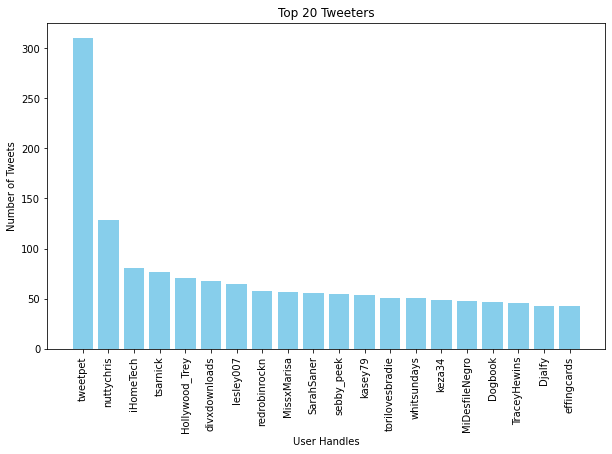

In [0]:
# Top 20 Tweeters Bar Chart
top_tweeters = tweets_by_user.limit(20).toPandas()


plt.figure(figsize=(10, 6))
plt.bar(top_tweeters['user'], top_tweeters['count'], color='skyblue')
plt.xlabel('User Handles')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=90)
plt.title('Top 20 Tweeters')
plt.show()


## 5.0 Transform the Bronze Data to Silver Data using a stream
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
# Read the Bronze Delta table as a stream
bronze_df = (
    spark.readStream
    .format("delta")
    .load(BRONZE_DELTA)  
)

def bronze_to_silver(bronze_dataframe):
    # Extract mentions from the text
    mentions_df = bronze_dataframe.withColumn("mentions", explode(split(regexp_replace(col("text"), "[^@\\w]", " "), " ")))
    mentions_df = mentions_df.filter(mentions_df.mentions.startswith("@"))
    
    # Create a cleaned_text column by removing mentions from the text
    cleaned_text_df = mentions_df.withColumn("cleaned_text", regexp_replace(col("text"), "@\\w+", ""))
    
    # Retain the sentiment as is
    silver_data = cleaned_text_df.withColumn("sentiment", col("sentiment"))
    
    return silver_data

# Transform the data
silver_data = bronze_to_silver(bronze_df)

# Write the transformed silver_data stream out to the Silver Delta table
silver_stream = (
    silver_data
    .writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", SILVER_CHECKPOINT)
    .queryName("silver_stream")  
    .start(SILVER_DELTA) 
)

In [0]:
silver_stream.status

Out[67]: {'message': 'Processing new data',
 'isDataAvailable': True,
 'isTriggerActive': True}

In [0]:
silver_tweet_count = spark.read.format("delta").load(SILVER_DELTA).count()

display(silver_tweet_count)

76164

In [0]:
silver_table_df = spark.read.format("delta").load(SILVER_DELTA)
display(silver_table_df.show())

+---------------+--------------------+---------+-------------------+--------------------+----------------+--------------------+
|           user|                text|sentiment|          timestamp|     processing_time|        mentions|        cleaned_text|
+---------------+--------------------+---------+-------------------+--------------------+----------------+--------------------+
|AussieJBlover89|@Lee_Knight lmao!...| positive|2009-04-07 05:53:25|2024-05-03 19:26:...|     @Lee_Knight| lmao! thanks Lee...|
|          Aly_S|@ddlovato I saw u...| positive|2009-04-07 05:53:28|2024-05-03 19:26:...|       @ddlovato| I saw u were on ...|
|       amyg0716|@ddlovato , i lov...| positive|2009-04-07 05:53:30|2024-05-03 19:26:...|       @ddlovato| , i lovee you  c...|
|   tinythoughts|@briancrouch yeah...| positive|2009-04-07 05:53:35|2024-05-03 19:26:...|    @briancrouch| yeah, you and i ...|
|      diegokobe|@markhoppus hey m...| positive|2009-04-07 05:33:33|2024-05-03 19:25:...|     @markhoppu

## 6.0 Transform the Silver Data to Gold Data using a stream
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:
# Load the pretrained transformer sentiment classifier
sentiment_analysis = pipeline(model=HF_MODEL_NAME, force_download=True)

# Define a UDF to apply sentiment analysis
def sentiment_score(text):
    result = sentiment_analysis(text)
    sentiment_label = result[0]['label']
    sentiment_map = {'POS': 1, 'NEU': 0, 'NEG': 0}  # Mapping sentiment to IDs
    sentiment_id = sentiment_map.get(sentiment_label, -1)  # Default to -1 if label not found
    return float(result[0]['score']), sentiment_label, sentiment_id

sentiment_udf = udf(sentiment_score, returnType=StructType([
    StructField("predicted_score", FloatType(), False),
    StructField("predicted_sentiment", StringType(), False),
    StructField("predicted_sentiment_id", IntegerType(), False)
]))


# Read the Silver Delta table as a stream
silver_df = (
    spark.readStream
    .format("delta")
    .load(SILVER_DELTA)
)

# Define the transformation logic from Silver to Gold
def silver_to_gold(silver_dataframe):
    gold_data = silver_dataframe.withColumn("sentiment_analysis", sentiment_udf(col("cleaned_text")))
    gold_data = gold_data.select(
        col("timestamp"),
        col("mentions"),
        col("cleaned_text"),
        col("sentiment"),
        col("sentiment_analysis.predicted_score").alias("predicted_score"),
        col("sentiment_analysis.predicted_sentiment").alias("predicted_sentiment"),
        col("sentiment_analysis.predicted_sentiment_id").alias("predicted_sentiment_id")
    )
    return gold_data

# Transform the data
gold_data = silver_to_gold(silver_df)

# Write the transformed gold_data stream out to the Gold Delta table
gold_stream = (
    gold_data
    .writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", GOLD_CHECKPOINT)
    .queryName("gold_stream")
    .start(GOLD_DELTA)
)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-f40cc00d-5e80-4f2c-8787-8559c15b8feb/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [0]:
gold_stream.status

Out[33]: {'message': 'Processing new data',
 'isDataAvailable': True,
 'isTriggerActive': True}

In [0]:
gold_tweet_count = spark.read.format("delta").load(GOLD_DELTA).count()

display(gold_tweet_count)

54548

In [0]:
gold_table_df = spark.read.format("delta").load(GOLD_DELTA)
display(gold_table_df.show())

+-------------------+----------------+--------------------+---------+---------------+-------------------+----------------------+
|          timestamp|        mentions|        cleaned_text|sentiment|predicted_score|predicted_sentiment|predicted_sentiment_id|
+-------------------+----------------+--------------------+---------+---------------+-------------------+----------------------+
|2009-04-07 05:28:34|@ninasplayground| I agree.  My kid...| positive|     0.68171245|                NEU|                     0|
|2009-04-07 05:22:53|@LutheranLucciol| Make sure you DM...| positive|     0.76346344|                POS|                     1|
|2009-04-07 05:42:49|    @TheLeagueSF| Not Fun &amp; Fu...| negative|       0.900836|                NEG|                     0|
|2009-04-07 05:33:33|     @markhoppus| hey mark, i want...| positive|     0.58266056|                NEU|                     0|
|2009-04-07 05:43:38| @SophieVeronica| today was rad. w...| positive|     0.99315065|            

## 7.0 Capture the accuracy metrics from the gold table in MLflow
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the mdoel name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

In [0]:
gold_data = spark.read.format("delta").load(GOLD_DELTA)

# A dictionary to map sentiments to numeric values
sentiment_to_id = {'POS': 1, 'NEU': 0, 'NEG': 0}

# Define a UDF to convert sentiment labels to numeric IDs
def sentiment_to_numeric(label):
    return sentiment_to_id.get(label, -1)  # Returns -1 if label is not in the dictionary

# Register UDF with Spark
sentiment_to_numeric_udf = udf(sentiment_to_numeric, IntegerType())

# Add a new column for numeric sentiment labels
gold_data = gold_data.withColumn("sentiment_id", sentiment_to_numeric_udf(col("predicted_sentiment")))

# Filter out rows where predicted_sentiment_id is null
filtered_data = gold_data.filter(col("predicted_sentiment_id").isNotNull())

# Select the predictions and the true labels
rdd = filtered_data.select(col("predicted_sentiment_id").cast("double"), col("sentiment_id").cast("double")).rdd

# Instantiate metrics object
metrics = MulticlassMetrics(rdd)

# Calculate metrics
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1_score = metrics.fMeasure(1.0)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


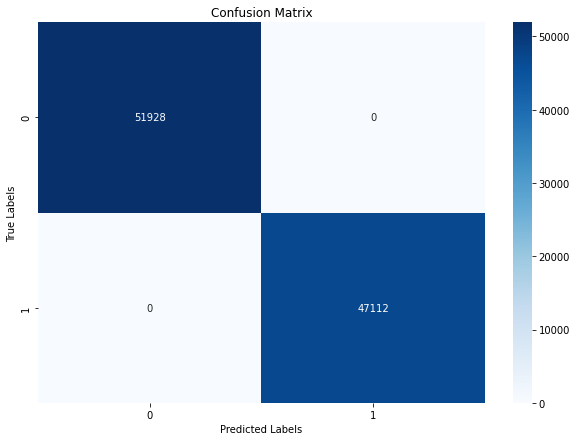

In [0]:
# Confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [0]:
# Start an MLflow run
with mlflow.start_run():
    # Log metrics
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1 Score", f1_score)

    # Log the confusion matrix image as an artifact
    mlflow.log_artifact('confusion_matrix.png', "confusion_matrix.png")

    # Log model name and MLflow version as parameters
    mlflow.log_param("Model Name", HF_MODEL_NAME)
    mlflow.log_param("MLflow Version", mlflow.__version__)

## 8.0 Application Data Processing and Visualization
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

You may want to use the "Loop Application" widget to control whether you repeateded display the latest plots while the data comes in from your streams before moving on to the next section and cleaning up your run.

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

In [0]:
# Load the Gold Delta Table
gold_data = spark.read.format("delta").load(GOLD_DELTA)

# Aggregate data to count sentiments for each mention and capture timestamps
mention_sentiment_count = gold_data.groupBy("mentions").agg(
    F.min("timestamp").alias("min_timestamp"),
    F.max("timestamp").alias("max_timestamp"),
    F.count(F.when(F.col("predicted_sentiment") == "NEU", True)).alias("neutral_count"),
    F.count(F.when(F.col("predicted_sentiment") == "POS", True)).alias("positive_count"),
    F.count(F.when(F.col("predicted_sentiment") == "NEG", True)).alias("negative_count"),
    F.count("*").alias("total_mentions")
).orderBy(F.desc("total_mentions"))


In [0]:
mention_sentiment_count.show(20)

+----------------+-------------------+-------------------+-------------+--------------+--------------+--------------+
|        mentions|      min_timestamp|      max_timestamp|neutral_count|positive_count|negative_count|total_mentions|
+----------------+-------------------+-------------------+-------------+--------------+--------------+--------------+
|               @|2009-04-07 05:28:15|2009-05-10 08:05:44|          531|           558|           371|          1460|
|     @mileycyrus|2009-04-07 05:38:51|2009-05-10 07:07:04|          115|           417|            76|           608|
|       @tommcfly|2009-04-07 05:22:49|2009-05-10 07:47:12|          108|           287|            49|           444|
|       @ddlovato|2009-04-07 05:42:52|2009-05-10 08:07:18|           97|           290|            45|           432|
|@JonathanRKnight|2009-04-07 05:21:53|2009-05-10 06:21:54|           61|           148|            34|           243|
|  @taylorswift13|2009-04-07 08:43:47|2009-05-10 03:26:0

In [0]:
def plot_top_mentions(dataframe, sentiment_column, title):
    top_mentions = dataframe.orderBy(F.desc(sentiment_column)).limit(20).toPandas()

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.barh(top_mentions['mentions'], top_mentions[sentiment_column], color='blue')
    plt.xlabel('Counts')
    plt.ylabel('Mentions')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to have the largest values on top
    plt.show()


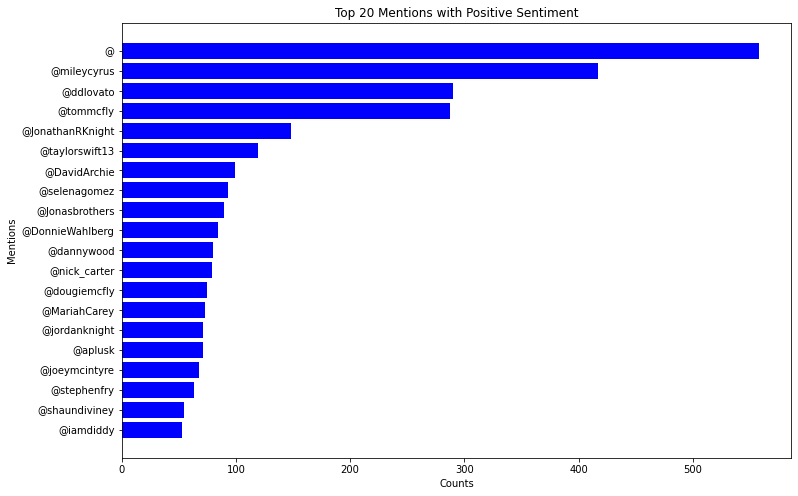

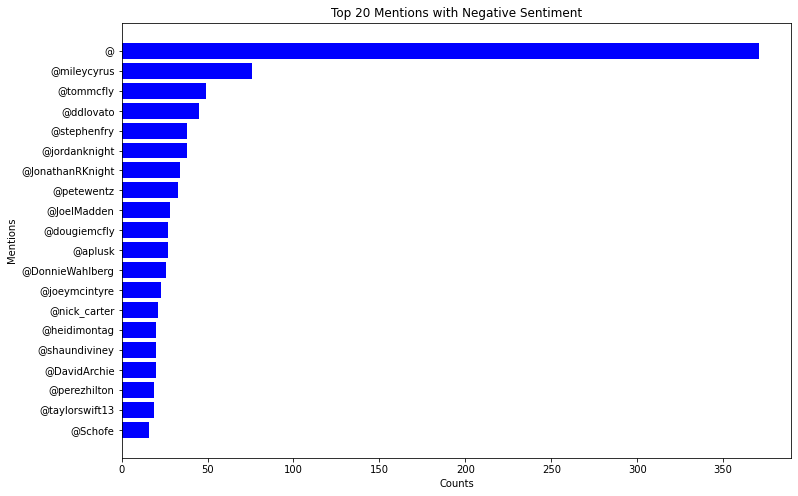

In [0]:
# Plot the top 20 mentions with positive sentiment
plot_top_mentions(mention_sentiment_count, 'positive_count', 'Top 20 Mentions with Positive Sentiment')

# Plot the top 20 mentions with negative sentiment
plot_top_mentions(mention_sentiment_count, 'negative_count', 'Top 20 Mentions with Negative Sentiment')

## 9.0 Clean up and completion of your pipeline
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook.

In [0]:
# ENTER YOUR CODE HERE
# Stop all active streams
for stream in spark.streams.active:
    stream.stop()
    print(f"Stopped stream: {stream.name}")

Stopped stream: gold_stream
Stopped stream: silver_stream
Stopped stream: None


In [0]:
import time

END_TIME = time.time()

# Calculate the elapsed time in seconds
elapsed_time = END_TIME - START_TIME

# Convert elapsed time to minutes and hours
elapsed_minutes = elapsed_time / 60
elapsed_hours = elapsed_minutes / 60

# Print the elapsed time in different units
print(f"Elapsed time: {elapsed_time:.2f} seconds ({elapsed_minutes:.2f} minutes, {elapsed_hours:.2f} hours)")


Elapsed time: 9486.64 seconds (158.11 minutes, 2.64 hours)


## 10.0 How Optimized is your Spark Application (Grad Students Only)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

### 10.0 How Optimized is my Spark Application 


Initially, the code faced issues like analytic connection errors, primarily due to the `maxFilesPerTrigger` being set to 1, which caused extremely slow data processing. Adjusting the partition size to 100, enabling adaptive query processing (AQE) by setting `spark.conf.get("spark.sql.adaptive.enabled")`, and increasing `maxFilesPerTrigger` to 1000 largely resolved these issues.

Upon inspecting the Spark UI, no spill was observed in any of the streaming tasks. Additionally, employing AQE in the initial task settings helped mitigate data skew. According to the "Stages" tab in the Spark UI, the uniform distribution of task durations and data sizes suggests that skew is not present.

The "Stages" tab also revealed that shuffle read and write metrics are minimal, with sizes ranging from 68 KiB to 500 bytes. This indicates efficient data partitioning, likely enhanced by optimized operations like joins and aggregations.

Observations from the "Storage" tab suggest potential inefficiencies in caching; a 0% cache hit ratio indicates that the current caching strategy might not be effective, possibly due to the nature of the wide transformations, such as joins, used in the streaming process.

Regarding serialization, as observed in the "Executor" tab:
1. **Storage Memory**: An executor is using 519.2 MiB of storage memory out of a total of 2.1 GiB available across all executors. This significant usage includes cached RDDs or DataFrames.
2. **Disk Used**: This same executor has utilized 517.1 MiB of disk space, some data or intermediate results had to be spilled to disk, potentially due to insufficient memory for caching or storage of all data in memory.

Given the modest shuffle sizes, the impact of serialization and deserialization overhead on system performance appears minimal.

- The following screenshots are provided for reference that address each of the 5S:
  - [Executor tab Screenshot](https://drive.google.com/file/d/1kbmzqbjXnbQhA2Hv6FRDZyd2Zd1kDgP1/view?usp=drive_link)
  - [Storage tab Screenshot](https://drive.google.com/file/d/1-8-PHXYShMet1DT3v4R5kayLpXCgUQTF/view?usp=drive_link)
  - [Shuffle Analysis Screenshot](https://drive.google.com/file/d/1tf08nyYPDWbTtGz1DnHCrwiBoF71iyG0/view?usp=drive_link)

